In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [3]:
# Load the data
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
# Add a new feature for sentiment analysis
train['sentiment'] = train['text'].apply(lambda text: TextBlob(text).sentiment.polarity)
test['sentiment'] = test['text'].apply(lambda text: TextBlob(text).sentiment.polarity)
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train[['text', 'sentiment']], train['generated'], test_size=0.2, random_state=42)
# Convert the text into a matrix of token counts
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train['text'])
X_val_counts = vectorizer.transform(X_val['text'])
# Convert sparse matrix to array for stacking
X_train_counts_array = X_train_counts.toarray()
X_val_counts_array = X_val_counts.toarray()
# Add the sentiment feature
X_train_combined = np.hstack((X_train_counts_array, X_train[['sentiment']].values))
X_val_combined = np.hstack((X_val_counts_array, X_val[['sentiment']].values))
# Feature engineering: Average length and word count
X_train['avg_length'] = X_train['text'].apply(lambda x: len(x.split()))
X_train['word_count'] = X_train['text'].apply(lambda x: len(x.split()))
X_val['avg_length'] = X_val['text'].apply(lambda x: len(x.split()))
X_val['word_count'] = X_val['text'].apply(lambda x: len(x.split()))
# Feature engineering: N-gram features
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_train_ngram = ngram_vectorizer.fit_transform(X_train['text'])
X_val_ngram = ngram_vectorizer.transform(X_val['text'])

# Combine all features
X_train_combined = np.hstack((X_train_combined, X_train[['avg_length', 'word_count']].values, X_train_ngram.toarray()))
X_val_combined = np.hstack((X_val_combined, X_val[['avg_length', 'word_count']].values, X_val_ngram.toarray()))

In [4]:
# Train SVM model
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_combined, y_train)

# Train logistic regression model
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_combined, y_train)

# Train XGBoost model
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train_combined, y_train)

# Ensemble method - Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_model), ('svm', svm_model), ('xgb', xgb_model)], 
    voting='soft'
)
voting_clf.fit(X_train_combined, y_train)

# Evaluate models
models = {'Logistic Regression': lr_model, 'SVM': svm_model, 'XGBoost': xgb_model, 'Voting Classifier': voting_clf}

for name, model in models.items():
    probs = model.predict_proba(X_val_combined)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, probs)
    roc_auc = auc(fpr, tpr)
    print(f'{name} - ROC AUC: {roc_auc:.4f}')


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression - ROC AUC: 0.9709
SVM - ROC AUC: 0.9891
XGBoost - ROC AUC: 0.9873
Voting Classifier - ROC AUC: 0.9855


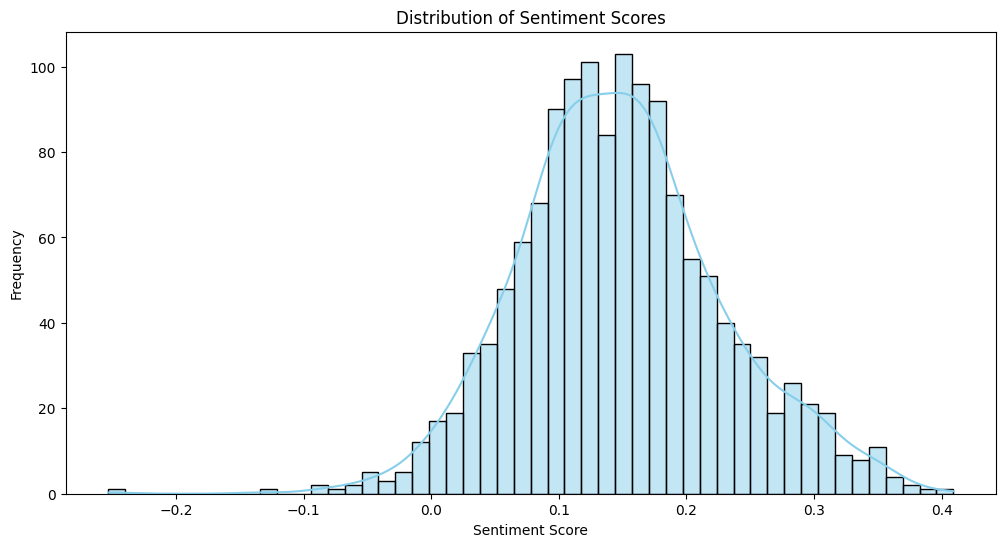

In [5]:
import seaborn as sns

# Visualize sentiment distribution
plt.figure(figsize=(12, 6))
sns.histplot(train['sentiment'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()




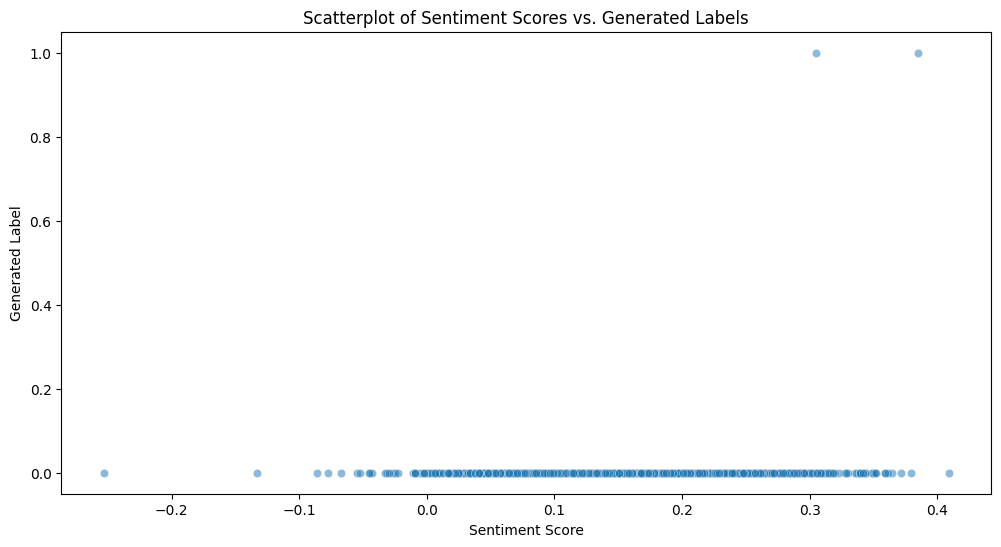

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment', y=y_train, data=X_train, alpha=0.5)
plt.title('Scatterplot of Sentiment Scores vs. Generated Labels')
plt.xlabel('Sentiment Score')
plt.ylabel('Generated Label')
plt.show()



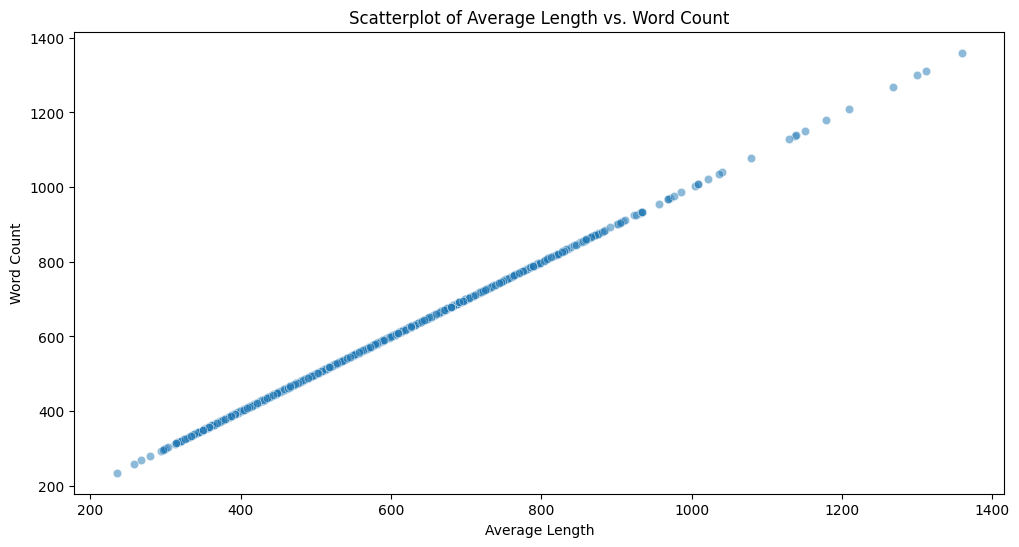

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='avg_length', y='word_count', data=X_train, alpha=0.5)
plt.title('Scatterplot of Average Length vs. Word Count')
plt.xlabel('Average Length')
plt.ylabel('Word Count')
plt.show()


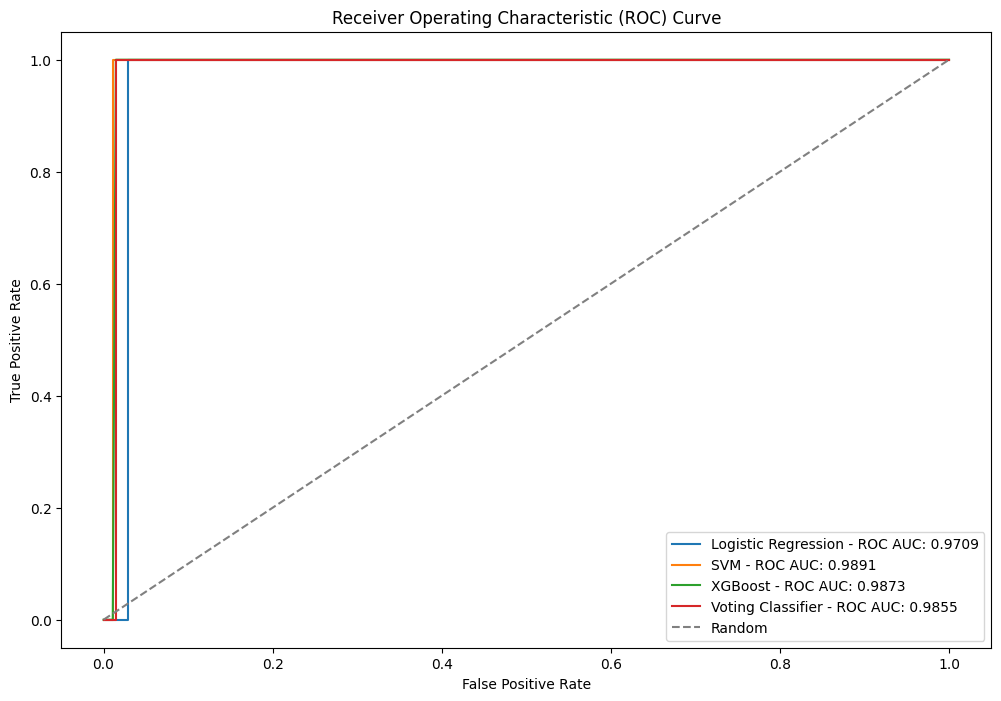

In [7]:
# ROC Curve for each model
plt.figure(figsize=(12, 8))
for name, model in models.items():
    probs = model.predict_proba(X_val_combined)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} - ROC AUC: {roc_auc:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

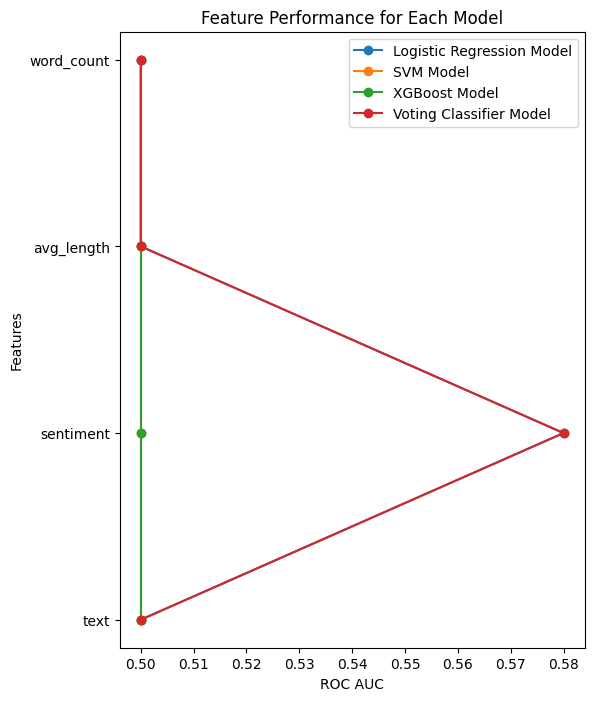

In [61]:

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate models and plot feature performance
feature_names = X_train.columns

plt.figure(figsize=(6,8))

for name, model in models.items():

    feature_performance = []

    for i, feature in enumerate(feature_names):
        # Create a subset of features including only the current one
        feature_indices = [j for j, col in enumerate(feature_names) if col == feature]
        X_val_subset = X_val_combined[:, feature_indices]

        # Train and predict using the current feature
        model.fit(X_train_combined[:, feature_indices], y_train)
        probs = model.predict_proba(X_val_subset)[:, 1]
        roc_auc = roc_auc_score(y_val, probs)
        feature_performance.append(roc_auc)

    # Plot feature performance for the current model
    plt.plot(feature_performance, np.arange(len(feature_performance)), label=f'{name} Model', marker='o', linestyle='-')

plt.yticks(np.arange(len(feature_performance)), feature_names)
plt.ylabel('Features')
plt.xlabel('ROC AUC')
plt.title('Feature Performance for Each Model')
plt.legend()
plt.show()




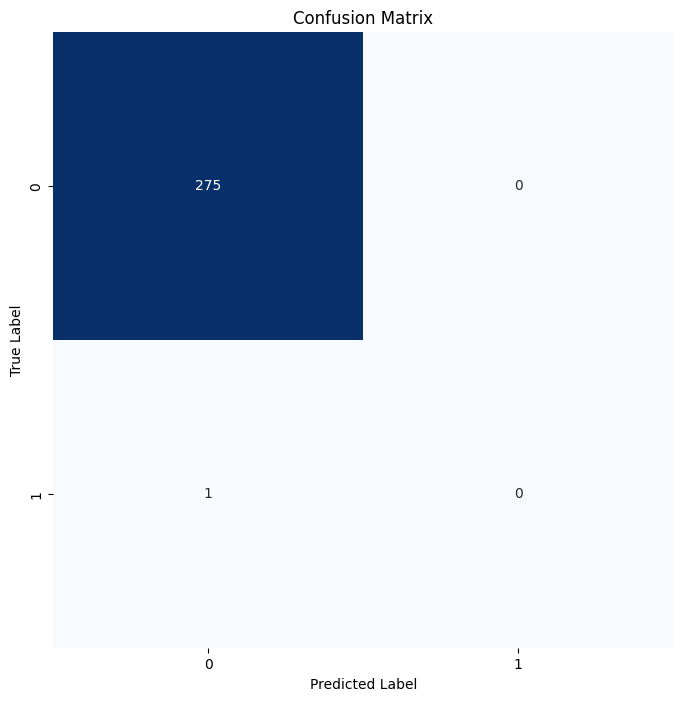

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 8))
cm_lr = confusion_matrix(y_val, lr_model.predict(X_val_combined))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

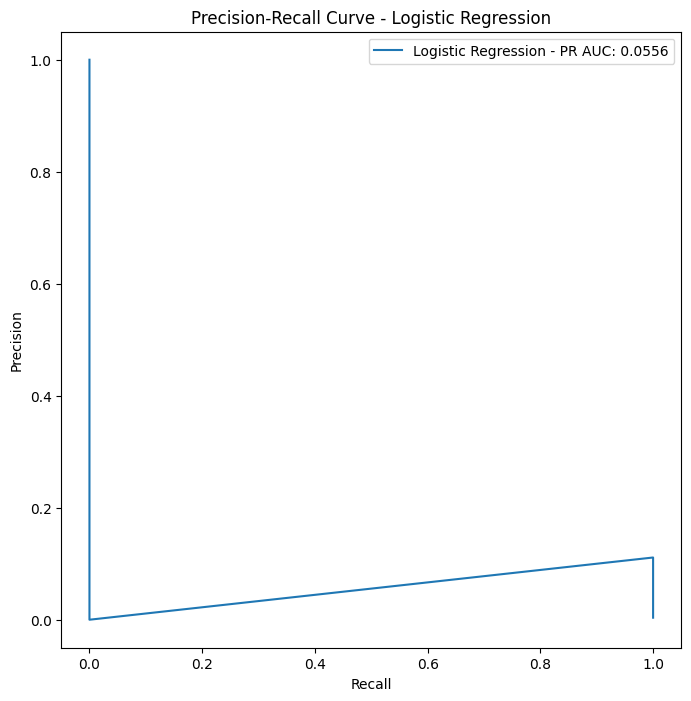

In [22]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_val, lr_model.predict_proba(X_val_combined)[:, 1])
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label=f'Logistic Regression - PR AUC: {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

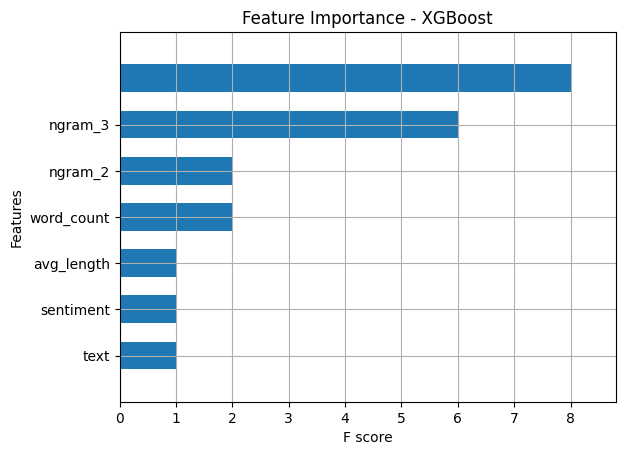

In [46]:
from xgboost import plot_importance

# Assuming X_train_combined is a DataFrame
feature_names = list(X_train.columns) + [f'ngram_{i}' for i in range(2, 4)]  # Adjust based on your features

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', show_values=False, height=0.6)
plt.yticks(range(len(feature_names)), feature_names)
plt.title('Feature Importance - XGBoost')
plt.show()




In [ ]:
# Make predictions on the validation set and calculate the ROC AUC score
y_val_pred = lr_model.predict_proba(X_val_combined)[:, 1]
print('Validation ROC AUC score:', roc_auc_score(y_val, y_val_pred))

# Prepare the submission file
X_test_counts = vectorizer.transform(test['text'])

# Add sentiment feature to test data
test_combined = np.hstack((X_test_counts.toarray(), test[['sentiment']].values))

# Feature engineering: Average length and word count
test['avg_length'] = test['text'].apply(lambda x: len(x.split()))
test['word_count'] = test['text'].apply(lambda x: len(x.split()))

# Feature engineering: N-gram features
X_test_ngram = ngram_vectorizer.transform(test['text'])

# Combine all features for test data
X_test_combined = np.hstack((test_combined, test[['avg_length', 'word_count']].values, X_test_ngram.toarray()))

# Make predictions on the test set
test['generated'] = lr_model.predict_proba(X_test_combined)[:, 1]

# Save the submission file
test[['id', 'generated']].to_csv('submission.csv', index=False)